<p class="title"> Confidence intervals based on the normal approximation</p>

One of the first things most statisticians would consider is to use confidence based on the normal approximation, especially if it were possible to draw a moderately large sample (e.g., 100 or more units).

The procedure would be:
+ choose the desired coverage probability $1-\alpha$ and the sample size $n$
+ draw a simple random sample or a random sample with replacement of size $n$ from the population
+ compute the sample mean $\bar{X}$ and sample standard deviation $s$
+ find $\hat{SE} = f \times s/\sqrt{n}$, the estimated standard error of the sample mean, where $f=1$ for sampling with replacement, and $f = \sqrt{\frac{N-n}{N-1}}$ for sampling without replacement ($N$ is the
population size)
+ find $t$, the appropriate critical value of Student's t distribution with $n-1$ degrees of freedom
+ the approximate 2-sided confidence interval is $[\bar{X} - t \hat{SE}, \bar{X} + t \hat{SE}]$.

### _Formally_, this gives an approximate confidence interval, but there's no guarantee that the actual coverage probability is close to the nominal coverage probability

+ Normal approximation is common, but can be grossly inaccurate, especially with:
  - small sample sizes
  - skewed populations
  
In auditing situations, typical for the distributions to be very skewed: point mass at zero, mixed with something else.

+ Examine scenarios by simulation.
+ First scenario is a population of zeros and ones, in various proportions
+ Second scenario is "nonstandard" mixture of pointmass at 0 and a Uniform

We are estimating the coverage by simulation. 

For simulations:

+ it's important to know which pseudo-random number generator (PRNG) you are using (Python uses the Mersenne Twister by default)
+ it's important to assess whether that PRNG is adequate  (the Mersenne twister is pretty good for statistical simulations, but not good enough for cryptographic applications)
+ it's important to remember that your estimates will have sampling error
+ if the result matters, you should quantify the sampling error, for instance, by a confidence interval for the estimated result.

Here, we will use 1000 or 10,000 iterations in the estimates. For estimating probabilities, the standard error of the result is no larger than $1/(2\sqrt{n})$: 1.58% for $n=1000$ and 0.5% for $n=10,000$.

For estimating things like expected length, guarantees of accuracy are harder, but the kinds of techniques we will see over this short course can be applied to _that_ problem too.

In [1]:
# This is the first cell with code: set up the Python environment
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import scipy.stats
from scipy.stats import binom
import pandas as pd
# For interactive widgets
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

In [2]:
# Population of two values, {0, 1}, in various proportions.  Amounts to Binomial random variable
ns = np.array([25, 50, 100, 400])  # sample sizes
ps = np.array([.001, .01, 0.1])    # mixture fractions, proportion of 1s in the population
alpha = 0.05  # 1- (confidence level)
reps = 1.0e4   # just for demonstration
vals = [0, 1]

simTable = pd.DataFrame(columns=('fraction of 1s', 'sample size', 'Student-t cov', 'Student-t len'))
for p in ps:
    popMean = p
    for n in ns:
        tCrit = sp.stats.t.ppf(q=1-alpha/2, df=n-1)
        samMean = sp.stats.binom.rvs(n, p, size=reps)/float(n)
        samSD = np.sqrt(samMean*(1-samMean)/(n-1))
        cover = ( np.fabs(samMean-popMean) < tCrit*samSD).sum()
        aveLen = 2*(tCrit*samSD).mean()
        simTable.loc[len(simTable)] =  p, n, str(100*float(cover)/float(reps)) + '%', str(round(aveLen,4))
#
ansStr =  '<h3>Simulated coverage probability and expected length of Student-t confidence intervals for a {0, 1} population</h3>' +\
          '<strong>Nominal coverage probability ' + str(100*(1-alpha)) +\
          '%</strong>.<br /><strong>Estimated from ' + str(reps) + ' replications.</strong>'

display(HTML(ansStr))
display(simTable)

,fraction of 1s,sample size,Student-t cov,Student-t len
0,0.001,25,2.66%,0.0044
1,0.001,50,4.92%,0.004
2,0.001,100,9.09%,0.0037
3,0.001,400,32.27%,0.0035
4,0.01,25,21.21%,0.0367
5,0.01,50,39.05%,0.0346
6,0.01,100,64.31%,0.0311
7,0.01,400,90.67%,0.0188
8,0.1,25,92.73%,0.2326
9,0.1,50,87.61%,0.1669


## Why/When is the coverage bad?

+ Because of the high population mass at 0, the sample will often contain _only_ 0s. Then the SD will be zero, the length of the interval will be 0, and the interval won't cover the mean&mdash;which is bigger than zero.
+ In general, coverage will be bad when sampling distribution of the sample mean is strongly skewed

E.g., Binomial with very small or very large $p$.

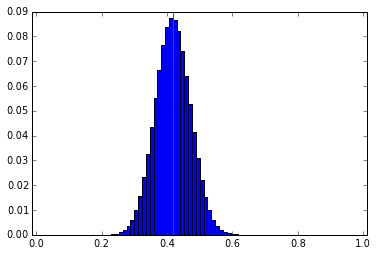

In [3]:
def plotBinomialPmf(n, p):
    '''
       Plots the sampling distribution of the sample mean of a sample of size n
       drawn with replacement from a {0, 1} population; i.e., a scaled binomial.
       Plots a vertical red line at the expected value.
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1)
    x = np.arange(n+1)
    xFrac = x.astype(float)/ x.max()
    width = 1.0/n
    ax.bar(xFrac, binom.pmf(x, n, p), width, align="center")
    plt.xlim([-width,1+width])
    plt.axvline(x=p, color='r')

interact(plotBinomialPmf, n=widgets.IntSliderWidget(min=5, max=300, step=5, value=30),\
         p=widgets.FloatSliderWidget(min=0.001, max=1, step=0.001, value=.001))

## Nonstandard mixtures of distributions

+ Common in statistical study of auditing to consider "nonstandard mixtures" of a pointmass and continuous distribution 
+ E.g., NRC Monograph and [1989 Statistical Science article](http://projecteuclid.org/download/pdf_1/euclid.ss/1177012665)
+ Let's look at a mixture of $U[0,1]$ and a pointmass at zero

In [13]:
# Nonstandard mixture: a pointmass at zero and a uniform[0,1]
ns = np.array([25, 50, 100, 400])  # sample sizes
ps = np.array([0.9, 0.99, 0.999])    # mixture fraction, weight of pointmass
alpha = 0.05  # 1- (confidence level)
reps = 1.0e4   # just for demonstration

simTable = pd.DataFrame(columns=('mass at 0', 'sample size', 'Student-t cov', 'Student-t len'))
for p in ps:
    popMean = (1-p)*0.5  #  p*0 + (1-p)*.5
    for n in ns:
        tCrit = sp.stats.t.ppf(q=1-alpha/2, df=n-1)
        cover = 0
        totLen = 0.0
        samMean = np.zeros(reps)
        for rep in range(int(reps)):
            sam = np.random.uniform(size=n)
            ptMass = np.random.uniform(size=n)
            sam[ptMass < p] = 0.0
            samMean[rep] = np.mean(sam)
            samSD = np.std(sam, ddof=1)
            cover += ( math.fabs(samMean[rep]-popMean) < tCrit*samSD )
            totLen += 2*tCrit*samSD
        simTable.loc[len(simTable)] =  p, n, str(100*float(cover)/float(reps)) + '%', str(round(totLen/reps,4))
#
ansStr =  '<h3>Simulated coverage probability and expected length of Student-t confidence intervals for mixture of U[0,1] and ' +\
          'pointmass at 0.</h3>' +\
          '<h4>Nominal coverage probability ' + str(100*(1-alpha)) +\
          '%.</h4> Estimated from ' + str(reps) + ' replications.'

display(HTML(ansStr))
display(simTable)

,mass at 0,sample size,Student-t cov,Student-t len
0,0.9,25,90.2%,0.6407
1,0.9,50,98.83%,0.6735
2,0.9,100,99.99%,0.6817
3,0.9,400,100.0%,0.6867
4,0.99,25,22.07%,0.0961
5,0.99,50,39.1%,0.1265
6,0.99,100,62.12%,0.1598
7,0.99,400,97.86%,0.2108
8,0.999,25,2.39%,0.0098
9,0.999,50,5.03%,0.0138


Again the distribution of the sample mean is skewed, which hurts the coverage of Student-t intervals. 

When the mass at 0 gets large enough, there is again a large chance that the sample will contain _only_ 0s, in which case the sample SD will be zero, the length of the interval will be zero, and the interval won't cover.

## Summary

* The actual coverage probability of confidence intervals based on the normal approximation can be *much* less than the nominal coverage probability, even for large-ish sample sizes, for skewed population distributions.
* In many applications, the population _is_ very skewed: "Nonstandard mixture distributions"
* For example, accounting overstatements might be mostly 0, and occasionally large. Then:
   * Can be very likely that the sample variance is zero
   * Leads to apparent certainty that the result is correct.

## What's next?
We will consider some conservative methods for constructing confidence bounds by inverting hypothesis tests.

- [Next: Duality between hypothesis tests and confidence sets](duality.ipynb)
- [Previous: Canonical examples of real-world problems we will consider](canonical.ipynb)
- [Index](index.ipynb)

In [17]:
%run talkTools.py